# TMS Stimulation

In [1]:
import numpy as np
from tvb.simulator.lab import * 
from mpl_toolkits.mplot3d import Axes3D

from simulation import *
from tms_coil import *
from visualise import *
from stimulus import *
from utils import *

label_font = 16
title_font = 24
legend_font = 12

%pylab nbagg
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


### Define models

In [2]:
# Jansen Rit extended
from tvb.basic.neotraits.api import NArray, List, Range
class ExtendedJansenRit(models.JansenRit): # Extension to the model due to an update of TVB
    variables_of_interest = List(of=str, label="Variables watched by Monitors", choices=(['y1-y2', 'y0','y1','y2','y3','y4','y5']), default=(['y1-y2']))

# Basic Jansen Rit model setup
jrm = ExtendedJansenRit(v0 = np.array([6.]))
# rww = models.ReducedWongWang();

# # Recreate parameters from Momi et al. 2022, fitting results grand mean (gm) of all 19 subjects from model_fit.ipynb
jrm_momi = ExtendedJansenRit(
                        a = np.array([0.0968777]),
                        b = np.array([0.05251]),
                        a_1 = np.array([0.97352]), # i.e. 131.4257
                        a_2 = np.array([0.81936]), # i.e. 110.6160
                        a_3 = np.array([0.21727]), # i.e. 29.3317
                        a_4 = np.array([0.23031]), # i.e. 31.0919
                        v0 = np.array([6.])
                        )

In [4]:
# Define the model
neuron_model = jrm
neuron_model.configure()

# Normalize the SC weights like in Triebkorn et al. 2020 - this has to be done because the averaged HCP subject has some outliers in the weights.txt file
weights_hcp=np.log(np.loadtxt('./data/HC/weights_HCP.txt')+1) # SCnew = log(SC+1)
weights_new=weights_hcp/weights_hcp.max() # Normalize

# Define the connectivity between regions
#white_matter = connectivity.Connectivity.from_file()
#white_matter = connectivity.Connectivity.from_file('/Users/timo/TVB/TVB_Distribution/tvb_data/tvb_data/berlinSubjects/QL_20120814/QL_20120814_Connectivity.zip') # for desikan killiany atlas
white_matter = connectivity.Connectivity(
    tract_lengths=np.loadtxt('./data/HC/tract_lengths_HCP.txt'),
    weights=weights_new,
    region_labels=np.loadtxt('./data/HC/region_labels_HCP.txt', dtype=str),
    centres=np.array([0]))
#white_matter.speed = np.array([4.0])
white_matter.configure()

# Define the coupling
white_matter_coupling = coupling.SigmoidalJansenRit(a=np.array([0.0]))
white_matter_coupling.configure()

# Define an integration method
dtx = 1.0 # Always think - how detailed shall my output be? More than 1ms steps are unnecessary
# heunint = integrators.HeunDeterministic(dt=dtx)

phi_n_scaling = (
            neuron_model.a
            * neuron_model.A
            * (neuron_model.p_max - neuron_model.p_min)
            * 0.5
        ) ** 2 / 2.0
nsig = np.zeros(6)
nsig[3] = phi_n_scaling
heunint = integrators.HeunStochastic(dt=dtx)


In [5]:
np.save('./data/labels_tvb.npy', white_matter.region_labels)

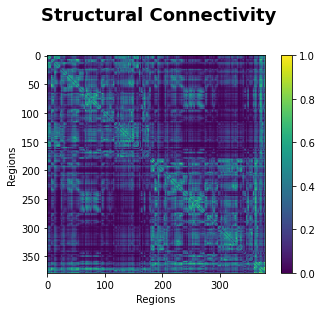

In [6]:
plt.imshow(np.asarray(weights_new))
plt.colorbar()
plt.xlabel("Regions")
plt.ylabel("Regions")
plt.suptitle("Structural Connectivity", fontweight="bold", fontsize="18", y = 1.05)
plt.show()

### Coil & EF choice

Choose coil type, coil position, field scale for stimulus weighting and cutoff value for stimulus propagation

In [7]:
# Choose TMS coil from "fig8" and "circular"
coil_choice = TMS_coil(type="fig8")

# Choose coil position from position list
ind = 16

# Choose field scale
field_scale = 5e1

# Choose cutoff value (MNI space coordinates) for stimulus weighting
cutoff_stim = 90 # usually it is around 90/100 for a decent cutoff


coil, coil_pts, xs, ys = coil_choice.get_tms_coil()
#figure(figsize=(6, 3))
#plot_coil_shape(xs, ys, coil_choice.type)

#weighting = coil_choice.get_electric_field_strength(white_matter.centres, ind, cutoff_stim) * field_scale

#figure(figsize=(5, 5))
#plot_coil_on_cortical_surface(coil, ind, default_cortex, title=coil_choice.pos_list[ind])
#coil_choice.get_stimulus_distribution(weighting, white_matter.region_labels, ind)

Index numbers of coil positions
0 	 Occipital
1 	 Occipital-Right
2 	 Right
3 	 Frontal-Right
4 	 Frontal
5 	 Frontal-Left
6 	 Left
7 	 Occipital-Left
8 	 Occipital-Cranial-Central
9 	 Cranial
10 	 Frontal-Cranial-Central
11 	 Frontal-Cranial-Right
12 	 Cranial-Right
13 	 Occipital-Cranial-Right
14 	 Occipital-Cranial-Left
15 	 Cranial-Left
16 	 Frontal-Cranial-Left


In [8]:
# using HCP MMP1 atlas


# import json and file with results from SimNIBS simulation
import json
# EF_file = '/home/anujanegi/tj/TMS-simulation/data/electric_fields/ernie−leftM1/ernie_EF_normE.json'
EF_file = '/home/anujanegi/tj/TMS-simulation/data/electric_fields/ernie FC6/ernie_EF_normE.json'
with open(EF_file, 'r') as f:
    EF_data = json.load(f)

# # modify SimNIBS result to make it compatible with TVB
ef_idxRegions = EF_data.copy()
# # for DK, there is no corpus callosum in TVB, but in SimNIBS - so delete it
# del ef_idxRegions['lh.corpuscallosum']
# del ef_idxRegions['rh.corpuscallosum']
# # adjust name structure of SimNIBS output to name structure of TVB
ef_idxRegions = { f'L_{k[3:]}' if 'lh.' in k else f'R_{k[3:]}': v for k, v in ef_idxRegions.items() }

# # get region labels and index from white matter
regions_li = white_matter.get_grouped_space_labels()

# # match region to tvb index to get TVB stimulus weighting
efield = {}
for key, value in ef_idxRegions.items():
    for hemi, regions in regions_li:
        for idx, area in regions:
            if area.lower() == key.lower():
                efield[(idx, area)] = value

# define spatial pattern of stimulus
# extract number of nodes & their stimulus weighting values from SimNIBS output
chosenNodes = [i for i, e in efield.keys()]
chosenNodes_weights = list(efield.values())
stim_simnibs = np.zeros(white_matter.number_of_regions)
# create a list of weighting in the order of white_matter.region_labels
stim_simnibs[chosenNodes] = np.array(chosenNodes_weights) * field_scale

coil_choice.get_stimulus_distribution(stim_simnibs, white_matter.region_labels, ind)
#labels name: https://bitbucket.org/dpat/tools/raw/master/REF/ATLASES/HCP-MMP1_UniqueRegionList.csv

Stimulus distribution at chosen coil position: Frontal-Cranial-Left

Region index    Region label    Stimulus weighting
55              R_6v            52.70347601562164
98              R_43            44.03300858131353
81              R_IFSa          41.134375844370055
73              R_44            39.560638711836475
74              R_45            37.8000364497121
82              R_p9-46v        37.33947939381036
80              R_IFSp          37.28220998498731
84              R_a9-46v        32.85905860882531
99              R_OP4           31.831999681620026
77              R_6r            31.46381903231554
174             R_A4            31.269567568233953
146             R_PFop          30.576416205870615
170             R_p47r          29.869477894486124
11              R_55b           29.55414907130512
115             R_PFt           29.415031361324033
75              R_47l           29.1024133860375
83              R_46            28.79113810069901
9               R_FEF    

In [9]:
stim_simnibs[10]

21.489023815597704

## Define stimulus

Choose stimulus pattern, stimulus onset and total duration of the stimulation:

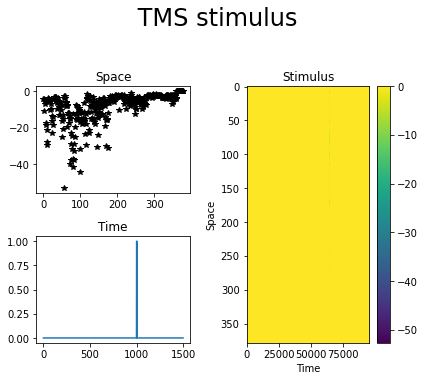

In [10]:
# Choose stimulus shape from "SinglePulse", "rTMS", "iTBS"
stim_pattern = "rTMS"

# Choose total stimulation length
duration = 1.5e3

# Choose first stimulus timing
st_ons = 1e3

# Choose length of one stimulation pulse in ms
st_len = 5.0

# Choose frequency for rTMS stimulus in ms (e.g. 200 for 5 Hz)
st_freq = 500.0

stim = get_stimulus(stim_simnibs*-1, white_matter, onset=st_ons, frequency=st_freq, duration=duration, type='rTMS')
plot_stimulus(stim)
# stim = get_stimulus(stim_simnibs*-1, white_matter, 0.1, 1e3, duration, st_len, st_freq, type=stim_pattern)
# plot_stimulus(stim, coil_choice.pos_list[ind], type=stim_pattern)

,value
Spatial equation,DiscreteEquation
Spatial parameters,{}
Temporal equation,PulseTrain
Temporal parameters,"{'T': 500.0, 'tau': 5.0, 'amp': 1.0, 'onset': 1000.0}"
Type,StimuliRegion


In [19]:
stim_simnibs.shape

(379,)

### Define monitors

In [11]:
monitors_needed = ["raw"] 
all_mons = get_monitors(monitors_needed)
all_mons

# for eeg monitor you need the region mapping and blah

In [15]:
# # Adjust monitors
# mon_raw = monitors.Raw()
# mon_raw.configure()

# mon_tavg = monitors.TemporalAverage(period=1.0)
# mon_tavg.configure()

# mon_savg = monitors.SpatialAverage(period=1.0)
# mon_savg.configure()

# mon_eeg = monitors.EEG.from_file()

# # mon_eeg = monitors.EEG.from_file(region_mapping=region_mapping.RegionMapping.from_file('/Users/timo/TVB/TVB_Distribution/tvb_data/tvb_data/regionMapping/regionMapping_16k_192.txt'),
# #                                  #sensors=sensors.SensorsEEG('/Users/timo/TVB/TVB_Distribution/tvb_data/tvb_data/sensors/eeg_brainstorm_65.txt'),
# #                                 period=1.0)
# mon_eeg.configure()

# # mon_bold = monitors.Bold(period=100) 
# # mon_bold.configure()

# # We have to define both all_mons and monitors_needed - this is a leftover of old code, fix that at some point
# all_mons = (mon_raw, mon_tavg, mon_eeg)
# monitors_needed = ["raw","tavg", "eeg"]

### Define initial conditions

In [21]:
# # same shape as history - [timepoints, state_variables, nodes, modes]
# init = np.random.rand(1,6,white_matter.weights.shape[0],1) # region based simulations
# #init = np.random.rand(1,6,default_cortex.vertices.shape[0],1) * 10 # surface based simulations

### Define the simulator

In [12]:
#resting state simulation
rs_sim = simulator.Simulator(model=neuron_model,
                          connectivity=white_matter,
                          coupling=white_matter_coupling,
#                           coupling=coupling.Linear(), #for wong wang
#                           noise=Additive(pyargs('nsig', 1e-4)), #ffor wong wang
                          integrator=heunint,
#                           surface=default_cortex,
                          monitors=all_mons,
                          #initial_conditions = init
                         )
rs_sim.configure()

# #resting state simulation
# rs_sim = simulator.Simulator(model=neuron_model,
#                           connectivity=white_matter,
#                           coupling=white_matter_coupling,
#                           integrator=heunint,
#                           #surface=default_cortex,
#                           monitors=all_mons,
#                           #initial_conditions = init
#                          )
# rs_sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 63336dbc-79e6-4502-aa5e-8b51cef0dac4
coupling,SigmoidalJansenRit gid: d2763f9e-9187-4ac4-9704-e164c7765a44
gid,UUID('e6db45fd-eace-45dd-8de5-e9e76402a699')
initial_conditions,None
integrator,HeunStochastic gid: ef71a885-5308-45a8-bba3-0d0be1e41c48
model,ExtendedJansenRit gid: 87beeb6d-9cce-4d44-936d-9a39fb0a6de7
monitors,[]
simulation_length,1000.0


In [13]:
# tms simulation
tms_sim = simulator.Simulator(model=neuron_model,
                          connectivity=white_matter,
                          coupling=white_matter_coupling,
#                           coupling=coupling.Linear(), #for wong wang
                          integrator=heunint,
                          #surface=default_cortex,   
                          monitors=all_mons,
                          stimulus=stim,
                          #initial_conditions = init
                         )
tms_sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 63336dbc-79e6-4502-aa5e-8b51cef0dac4
coupling,SigmoidalJansenRit gid: d2763f9e-9187-4ac4-9704-e164c7765a44
gid,UUID('99f104e9-6658-4f79-99e1-a3f8c4c7c03e')
initial_conditions,None
integrator,HeunStochastic gid: ef71a885-5308-45a8-bba3-0d0be1e41c48
model,ExtendedJansenRit gid: 87beeb6d-9cce-4d44-936d-9a39fb0a6de7
monitors,[]
simulation_length,1000.0


### Run simulation exploring global coupling

In [16]:
# %%time
def find_roots(x,y):
    s = np.abs(np.diff(np.sign(y))).astype(bool)
    return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

def run_sim(global_coupling):

#     rs_sim = simulator.Simulator(model=neuron_model,
#                           connectivity=white_matter,
#                           coupling=white_matter_coupling,
# #                           coupling=coupling.Linear(), #for wong wang
# #                           noise=Additive(pyargs('nsig', 1e-4)), #ffor wong wang
#                           integrator=heunint,
# #                           surface=default_cortex,
#                           monitors=all_mons,
#                           #initial_conditions = init
#                          )
#     rs_sim.configure()

        # tms simulation
    tms_sim = simulator.Simulator(model=neuron_model,
                              connectivity=white_matter,
                              coupling=white_matter_coupling,
    #                           coupling=coupling.Linear(), #for wong wang
                              integrator=heunint,
                              #surface=default_cortex,   
                              monitors=all_mons,
                              stimulus=stim,
                              #initial_conditions = init
                             )
    tms_sim.configure()
    
    # rs_sim.coupling.a = np.array([global_coupling])
    tms_sim.coupling.a = np.array([global_coupling])
    # rs_data = run_simulation(rs_sim, duration, monitors_needed)
    tms_data = run_simulation(tms_sim, duration, monitors_needed)
    
    # tavg_time, TAVG = rs_data["raw"]["time"], rs_data["raw"]["data"]
    tavg_time, TAVG_TMS = tms_data["raw"]["time"], tms_data["raw"]["data"]

    plt.figure(figsize=(10, 4))
#     plt.plot(tavg_time, TAVG[:, 0, [9,10,11], 0].mean(axis=1), alpha=1, label='Resting state')
    plt.plot(tavg_time, TAVG_TMS[:, 0, :, 0], "k", alpha=0.01)
    plt.plot(tavg_time, TAVG_TMS[:, 0, [9,10,11], 0].mean(axis=1), alpha=1, label='TMS applied over M1')
    # plt.plot(tavg_time, TAVG_TMS[:, 0, :, 0].mean(axis=1), alpha=1, label='TMS applied over M1')
    plt.title(f"Resting state vs TMS evoked potential; GC={global_coupling}")
    plt.xlabel("Time (ms)")
    plt.axvline(x=1000, color='r', linestyle='--', label='Stimulus')
    plt.axvline(x=1030, color="m", linestyle="--", label="P30") 
    
    x0=1030
    z=find_roots(TAVG_TMS[:, 0, [9, 10, 11], 0].mean(axis=1), tavg_time-x0)
    try:
        plt.plot(np.ones_like(z)*x0, z, marker="o", ls="", ms=10, color="limegreen", label = f"{np.round(z[0])}")
    except:
        pass
    plt.xlim(950, 1100)
#     plt.ylim(0,55)
    plt.ylim(-20,30)
    plt.legend()
    plt.show()
    
    return tms_data

/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))


The simulation took 13.6s to run


/home/anujanegi/anaconda3/envs/tvb_simnibs/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


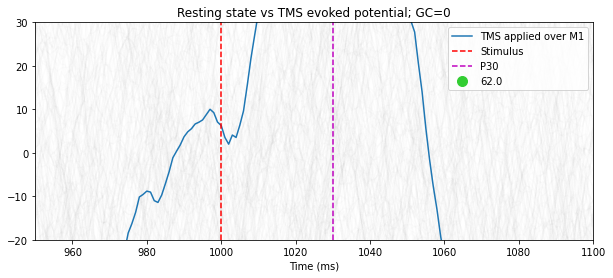

In [17]:
# import warnings
# warnings.filterwarnings('ignore')

import multiprocessing as mp
gc_range = np.arange(0,2,.2)

# run simulation in parallel - be sure that your computer has enough cores
n_cores = 4 # specify number of cores which should be used in parallel 
p = mp.Pool(processes=n_cores)
results = p.map(run_sim, [0])
p.close()


In [29]:
results[0]['raw']['time']
results[0]['raw']['data'][:,0,:,0].shape

(1500, 379)

(950.0, 1100.0)

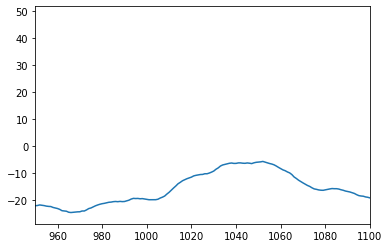

In [18]:
plt.plot(results[0]['raw']['time'], results[0]['raw']['data'][:,0,:,0].mean(axis=1))
plt.xlim(950, 1100)
# plt.xlim(-30, 10)

In [57]:
np.save('./data/raw_time.npy', results[0]['raw']['time'])
np.save('./data/raw_data.npy', results[0]['raw']['data'][:,0,:,0])

white_matter.re

## Visualisation

In [45]:
rs_data = run_simulation(rs_sim, duration, monitors_needed)
tms_data = run_simulation(tms_sim, duration, monitors_needed)

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/TVB_Distribution/tvb_data/lib/python3.7/site-packages/tvb/simulator/coupling.py:375: RuntimeWarning: overflow encountered in exp
  pre = self.cmax / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))
/home/anujanegi/TVB_Distribution/tvb_data/lib/python3.7/site-packages/numba/np/ufunc/gufunc.py:151: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)


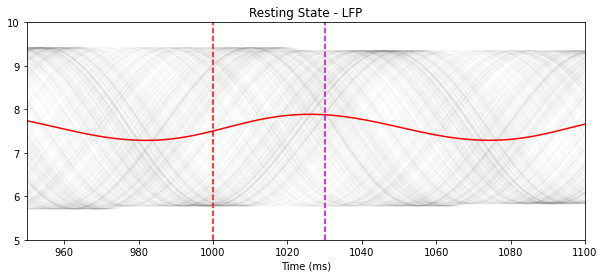

In [49]:
# Plot TAVG of resting state
tavg_time, TAVG = rs_data["raw"]["time"], rs_data["raw"]["data"]

plt.figure(figsize=(10, 4))
plt.plot(tavg_time, TAVG[:, 0, :, 0], "k", alpha=0.01)
plt.plot(tavg_time, TAVG[:, 0, :, 0].mean(axis=1), "r", alpha=1)
plt.title("Resting State - LFP")
plt.xlabel("Time (ms)")
# plt.xlim(800, 1500)
plt.axvline(x=1000, color='r', linestyle='--', label='Stimulus')
plt.axvline(x=1030, color="m", linestyle="--", label="P30") 
plt.xlim(950, 1100)

plt.ylim(5,10)
plt.show()

In [14]:
# Plot TAVG of TMS
# tavg_time, TAVG = tms_data["raw"]["time"], tms_data["raw"]["data"]
# TAVG_TMS = TAVG

plt.figure(figsize=(10, 4))
plt.plot(tavg_time, TAVG_TMS[:, 0, :, 0], "k", alpha=0.01)
plt.plot(tavg_time, TAVG_TMS[:, 0, :, 0].mean(axis=1), "r", alpha=1)
plt.title("TMS applyied- LFP")
plt.xlabel("Time (ms)")
# plt.xlim(2000, 8000)
plt.axvline(x=1000, color='r', linestyle='--', label='Stimulus')
plt.axvline(x=1030, color="m", linestyle="--", label="P30") 
plt.xlim(950, 1100)

plt.ylim(0,30)
plt.legend()
plt.show()

NameError: name 'tavg_time' is not defined

<Figure size 720x288 with 0 Axes>

In [57]:
tms_sim.coupling.a = np.array([0.5])
tms_data = run_simulation(tms_sim, duration, monitors_needed)

WARNING  random_state supplied for non-stochastic integration


/home/anujanegi/TVB_Distribution/tvb_data/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


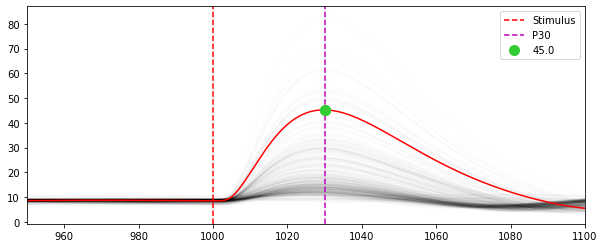

In [109]:
tavg_time, TAVG = tms_data["raw"]["time"], tms_data["raw"]["data"]
plt.figure(figsize=(10, 4))
plt.plot(tavg_time-1500, TAVG[:, 0, :, 0], "k", alpha=0.01)
plt.plot(tavg_time-1500, TAVG[:, 0, [9,10,11], 0].mean(axis=1), "r", alpha=1)
# plt.ylim(0,30)
plt.xlim(950, 1100)
plt.axvline(x=1000, color='r', linestyle='--', label='Stimulus')
plt.axvline(x=1030, color="m", linestyle="--", label="P30") 

x0=1030
z=find_roots(TAVG[:, 0, [9,10,11], 0].mean(axis=1), tavg_time-1500-x0)
plt.plot(np.ones_like(z)*x0, z, marker="o", ls="", ms=10, color="limegreen", label = f"{np.round(z[0])}")
plt.legend()
plt.show()

In [101]:
TAVG[:, 0, [9,10,11], 0].mean(axis=1)

array([5.33964043, 5.46625054, 5.62831959, ..., 7.65979335, 7.6225371 ,
       7.59007475])

In [105]:
# np.where(tavg_time==1030.)z# numpy.where(array == item)
z

array([45.25315093, 45.25315093])

In [90]:

def find_roots(x,y):
    s = np.abs(np.diff(np.sign(y))).astype(bool)
    return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

x0=1030
z=find_roots(TAVG[:, 0, [9,10,11], 0].mean(axis=1), tavg_time-1500-1030)


/home/anujanegi/TVB_Distribution/tvb_data/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


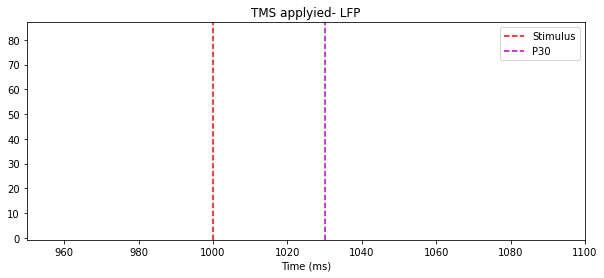

In [71]:
# Plot TAVG of TMS
tavg_time, TAVG = tms_data["raw"]["time"], tms_data["raw"]["data"]
# TAVG_TMS = TAVG

plt.figure(figsize=(10, 4))
plt.plot(tavg_time, TAVG[:, 0, :, 0], "k", alpha=0.01)
plt.plot(tavg_time, TAVG[:, 0, :, 0].mean(axis=1), "r", alpha=1)
plt.title("TMS applyied- LFP")
plt.xlabel("Time (ms)")
# plt.xlim(2000, 8000)
plt.axvline(x=1000, color='r', linestyle='--', label='Stimulus')
plt.axvline(x=1030, color="m", linestyle="--", label="P30") 
plt.xlim(950, 1100)

# plt.ylim(0,30)
plt.legend()
plt.show()

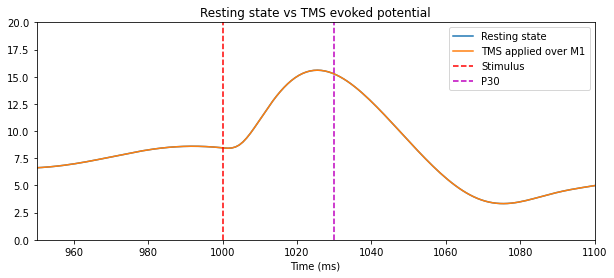

In [41]:
## This is with JR
plt.figure(figsize=(10, 4))
# plt.plot(tavg_time, TAVG[:, 0, :, 0], "k", alpha=0.01)
plt.plot(tavg_time, TAVG[:, 0, [9,10,11], 0].mean(axis=1), alpha=1, label='Resting state')
plt.plot(tavg_time, TAVG_TMS[:, 0, [9,10,11], 0].mean(axis=1), alpha=1, label='TMS applied over M1')
plt.title("Resting state vs TMS evoked potential")
plt.xlabel("Time (ms)")
# plt.xlim(2000, 8000)
plt.axvline(x=1000, color='r', linestyle='--', label='Stimulus')
plt.axvline(x=1030, color="m", linestyle="--", label="P30") 
plt.xlim(950, 1100)

plt.ylim(0,20)
plt.legend()
plt.show()

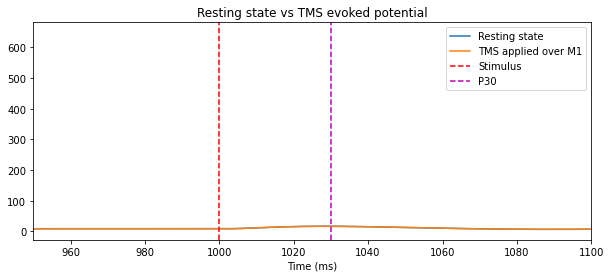

In [15]:
## THis is with JR momi
plt.figure(figsize=(10, 4))
# plt.plot(tavg_time, TAVG[:, 0, :, 0], "k", alpha=0.01)
plt.plot(tavg_time, TAVG[:, 0, [9,10,11], 0].mean(axis=1), alpha=1, label='Resting state')
plt.plot(tavg_time, TAVG_TMS[:, 0, [9,10,11], 0].mean(axis=1), alpha=1, label='TMS applied over M1')
plt.title("Resting state vs TMS evoked potential")
plt.xlabel("Time (ms)")
# plt.xlim(2000, 8000)
plt.axvline(x=1000, color='r', linestyle='--', label='Stimulus')
plt.axvline(x=1030, color="m", linestyle="--", label="P30") 
plt.xlim(950, 1100)

# plt.ylim(0,20)
plt.legend()
plt.show()

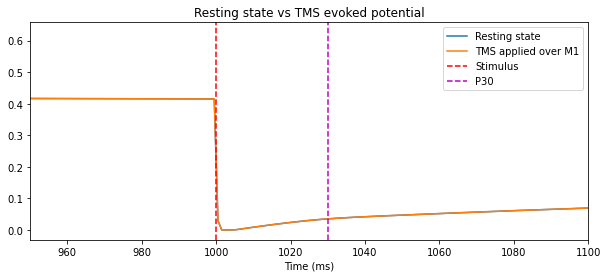

In [32]:
## THis is with Wong Wangg
plt.figure(figsize=(10, 4))
# plt.plot(tavg_time, TAVG[:, 0, :, 0], "k", alpha=0.01)
plt.plot(tavg_time, TAVG[:, 0, [9,10,11], 0].mean(axis=1), alpha=1, label='Resting state')
plt.plot(tavg_time, TAVG_TMS[:, 0, [9,10,11], 0].mean(axis=1), alpha=1, label='TMS applied over M1')
plt.title("Resting state vs TMS evoked potential")
plt.xlabel("Time (ms)")
# plt.xlim(2000, 8000)
plt.axvline(x=1000, color='r', linestyle='--', label='Stimulus')
plt.axvline(x=1030, color="m", linestyle="--", label="P30") 
plt.xlim(950, 1100)

# plt.ylim(0,20)
plt.legend()
plt.show()

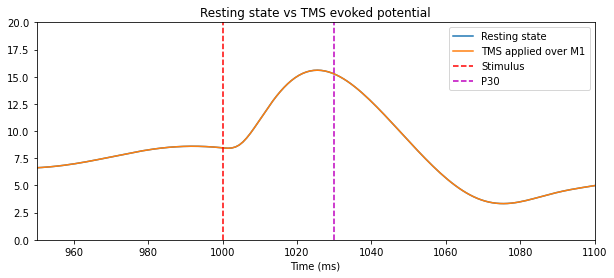

In [46]:
TAVG.shape

(1498, 1, 379, 1)

In [61]:
white_matter.region_labels[9:12]

array(['R_FEF', 'R_PEF', 'R_55b'], dtype='<U128')

Everything that comes from here on is unimportant for this simulation

In [21]:
#EOI=[3, 41, 42, 58] # Choose electrodes of interest
#EOI_labels=all_mons[1].sensors.labels[EOI] # Select index of EEG in all_mons
#start_window = 1450 # Choose start time point of visualization
#end_window = 1650 # Choose end time point of visualization

#plot_monitor_data_rs(rs_data, monitors_needed, start_window, end_window, duration, dtx, EOI, EOI_labels)
#plot_monitor_data_tms(tms_data, monitors_needed, start_window, end_window, duration, stim_pattern, st_ons, st_freq, dtx, EOI, EOI_labels)

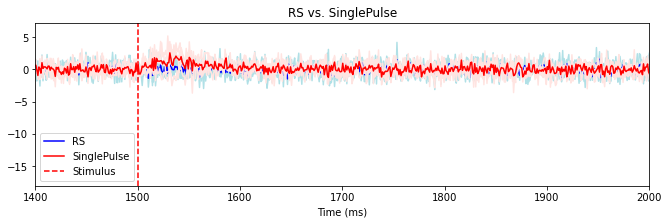

In [16]:
### RS vs TMS
end_window = 2000
plot_eeg_comparison(rs_data['eeg'], tms_data['eeg'], st_ons, stim_pattern, end_window)

### Extract TEPs and visualise them

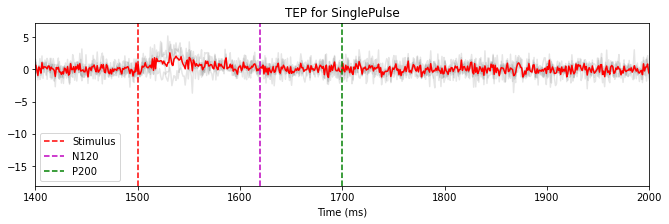

In [17]:
end_window = 2000
plot_TEP(tms_data['eeg'], st_ons, stim_pattern, end_window)

IndexError: index 73 is out of bounds for axis 0 with size 68

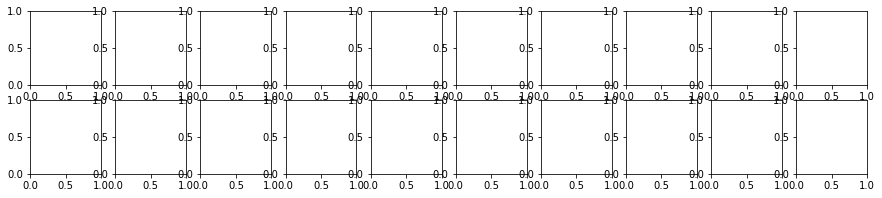

In [18]:
# Plot surface activity
a = int(st_ons) # stimulus onset time put into an int. variable
time_stamps = [a, (a+5), (a+10), (a+20), (a+30), (a+40), (a+50), (a+60), (a+100), (a+150)]
plot_activity_on_brain(default_cortex.vertices,default_cortex.triangles,default_cortex.region_mapping, rs_data['tavg'], time_stamps, "Resting state - temporal average")
plot_activity_on_brain(default_cortex.vertices,default_cortex.triangles,default_cortex.region_mapping, tms_data['tavg'], time_stamps, "Single Pulse TMS - temporal average")

In [15]:
eqn_t = equations.PulseTrain()
eqn_t.parameters["onset"] = st_ons  # Delay from beginning of sim [ms]
eqn_t.parameters["T"] = 20  # Frequency of pulse train [ms] #5Hz rTMS
eqn_t.parameters["tau"] = 5.0  # Period of pulse train [ms]
eqn_t.parameters.update()

In [17]:
eqn_t



,value
Equation type,PulseTrain
equation,"where((var>onset)&(((var-onset) % T) < tau), amp, 0)"
parameters,"{'T': 20, 'tau': 5.0, 'amp': 1.0, 'onset': 1000.0}"
